In [1]:
from IPython.core.debugger import set_trace
import unittest
tc = unittest.TestCase('__init__')

import numpy as np
from numpy.linalg import inv

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use = "default"
# mathjax docs: https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference

In [2]:
def p(*args):
    for arg in args:
        print(arg)
        print(" ")

# The Problem

Given $A \in \mathbb{R}^{mxn} \text{ and } b \in \mathbb{R}^n$ in the equation:

$Ax = b$
  
We want to solve for $x$

In [3]:
def ex_1():
    return (np.array([
        [4, -1, 2 ,-1],
        [2, 6, 3, -3],
        [1, 1, 5, 0],
        [1, -1, 4, 7]
    ], dtype=np.float64), 
    np.array([[-8, -20, -2, 4]], dtype=np.float64).T,
    np.array([[2, 2, 3, -7]], dtype=np.float64).T)


def ex_2():
    # slide 115
    return (
        np.array([
            [.2, .1, 1, 1, 0],
            [.1, 4, -1, 1, -1],
            [1, -1, 60, 0, -1],
            [1, 1, 0 , 8, 4],
            [0, -1, -2, 4, 700]            
        ]),
        np.array([1,2,3,4,5], dtype=np.float64).T,
        np.array([7.859713071, 0.4229264082, -.07359223906, -.5406430164, .01062616286], dtype=np.float64).T
    )

def ex_3():
    return (
        np.array([
            [4, 3, 0],
            [3, 4, -1],
            [0, -1, 4]
        ]),
        np.array([24, 30, -24]),
        np.array([3, 4, -5])
    )

def ex_4():
    return (
        np.array([
            [3.3330, 15920, -10.333],
            [2.2220, 16.710, 9.6120],
            [1.5611, 5.1791, 1.6852]
        ]),
        np.array([15913, 28.544, 8.4254]),
        np.array([1, 1, 1])
    )

def ex(number):
    if number == 1:
        return ex_1()
    elif number == 2:
        return ex_2()
    elif number == 3:
        return ex_3()
    elif number == 4:
        return ex_4()

In [69]:
def run_test(example_num, generate_plot, methods, iterations=-1):
    if not isinstance(methods, list):
        raise Exception("parameter `methods` must be a list of method declarations.")
        
    A, b, x = ex(example_num)
    errors = []
    max_err_length = -np.inf
    for method in methods:
        x, iter_vals = np.array(method(A, b, iterations))
        error = x - np.array(iter_vals)
        errors.append(error)

    if generate_plot:
        m_names = []
        plt.figure(figsize=(12, 7))
        
        for i, e in enumerate(errors):
            method_name = " ".join(methods[i].__name__.split("_"))
            plt.plot(np.linalg.norm(e, axis=1), label=method_name)
            m_names.append(method_name)
            
        plt.legend()
        plt.ylabel("norm")
        plt.xlabel("iteration")
        plt.title(", ".join(m_names) + " (example {})".format(example_num))
        
        plt.show()
    
    return errors

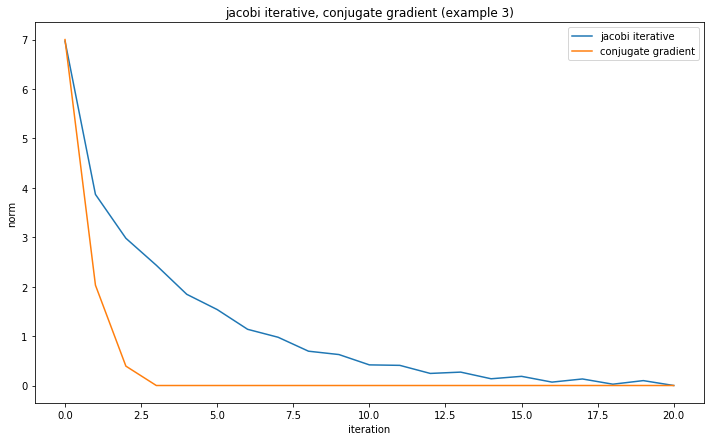

In [76]:
r = run_test(3, True, [jacobi_iterative, conjugate_gradient], 20)

# Gausse Elimination

### 1. No Pivoting:

In [6]:
def swap_rows(m, row_index_1, row_index_2):
    cpy = m.copy()
    cpy[[row_index_1, row_index_2]] = cpy[[row_index_2, row_index_1]]
    return cpy

def swap_rows_if_needed(m, b, pivot_row, pivot_col):
        if m[pivot_row, pivot_col] > 0:
            return m, b
        
        nonzeros = m[pivot_row: m.shape[0], pivot_col].nonzero()
        if len(nonzeros[0]) > 0:
            next_nonzero_index = nonzeros[0][0] + pivot_row
            if next_nonzero_index != pivot_row:
                m = swap_rows(m, pivot_row, next_nonzero_index)
                b = swap_rows(b, pivot_row, next_nonzero_index)

        return m, b

def swap_rows_if_needed_test():
    A = np.random.random((4,4))
    b = np.random.random((4,1))
    A[1, 1] = 0
    A_real, b_real = swap_rows_if_needed(A,b, 1, 1)
    A_expected = swap_rows(A, 1, 2)
    b_expected = swap_rows(b, 1, 2)
    tc.assertTrue(np.array_equal(A_expected, A_real))
    tc.assertTrue(np.array_equal(b_expected, b_real))
    
    B = np.random.random((4,4))
    c = np.random.random((4,1))
    B_real, c = swap_rows_if_needed(B, c, 1, 1)
    B_expected = B
    tc.assertTrue(np.array_equal(B_expected, B_real))
    
swap_rows_if_needed_test()

In [7]:
def forward_elimination(A_input, b_input):
    def forward_elimination_recurse(A, b, pivot_index):
        pivot_row_index = A.shape[1] - A.shape[0] + pivot_index
        A, b = swap_rows_if_needed(A, b, pivot_row_index, pivot_index)
        pivot_row = A[pivot_row_index]
        
        start_row_index = pivot_row_index + 1

        for row_i in range(start_row_index, A.shape[0]):
            multiplier = np.abs(pivot_row[pivot_index]) *  (A[row_i][pivot_index] / pivot_row[pivot_index])
            A[row_i] -= (multiplier * pivot_row)
            b[row_i] -= (multiplier * b[pivot_row_index])
        
        if pivot_index >= A.shape[1]-1:
            return A, b
        else:
            return forward_elimination_recurse(A, b, pivot_index + 1)
    
    return forward_elimination_recurse(A_input, b_input, 0)

In [8]:
# A -> n x m matrix, b -> 1 x m matrix
def backward_substitution(A, B):
    '''
    There are only m variables to solve for in an n x m matrix,
    so we can just solve the m x m submatrix. If m > n, we don't
    have enough equations to solve the system.

    x = output    
    n = # of rows
    k = # of columns
    '''
    x = np.zeros((B.shape[0],))
    n = A.shape[0]
    k = A.shape[1]
    
    # first iteration 
    x[k-1] = B[k-1, 0] / A[n-1,k-1]
    A[0: n-1,k-1] *= x[k-1]
    B[k-1] *= x[k-1]

    for i in reversed(range(0, k-1)):
        found_variables_sum = np.sum(A[i, i+1:n])
        x[i] = (B[i, 0] - found_variables_sum) / A[i, i]
        A[:i, i] *= x[i]

    if n > k:
        A[0: n-k] *= x
    
    return x[::-1]

In [9]:
def gauss_no_pivot(A, b):
    A, b = forward_elimination(A, b)
    return backward_substitution(A, b)

In [10]:
A, b, x = ex_1()

p_x = gauss_no_pivot(A, b)
p(p_x, x)

[-8.      7.6    -0.55   -7.9375]
 
[[ 2.]
 [ 2.]
 [ 3.]
 [-7.]]
 


### 2. Partial Pivoting

In [11]:
def gauss_partial_pivot(A, b):
    pass

# Jacobi Iterative Method

In [65]:
def jacobi_iterative(A, b, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    R = A - D
    L = np.tril(R)
    U = np.triu(R)
    inverse_D = inv(D)
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.ones(b.shape)
    iterations = [prev_x]
    i = 0
    
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inverse_D @ (b - (R @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    return x, iterations

In [66]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", jacobi_iterative(A,b, 3)[0], "x:", x)

Estimation:
 
[ 4.40625  5.875   -5.46875]
 
x:
 
[ 3  4 -5]
 


# Gauss-Seidel

In [43]:
def gauss_seidel(A, b, num_iterations = -1):
    L = np.tril(A)
    U = A - L
    x0 = np.random.random(b.shape)
    inv_L = inv(L) 
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.ones(b.shape)
    iterations = [prev_x]
    i = 0
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inv_L @ (b - (U @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    
    return x, iterations

In [68]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", gauss_seidel(A, b)[0], "x:", x)

Estimation:
 
[ 3.0083819   3.99301508 -5.00174623]
 
x:
 
[ 3  4 -5]
 


# Successive Over-Relaxation

In [45]:
def successive_over_relax(A, b, w, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    
    converg_thresh = .001
    
    error = np.inf
    i = 0
    prev_x = np.ones(b.shape)
    while i < iterations if num_iterations > 0 else error > converg_thresh:
        # https://en.wikipedia.org/wiki/Successive_over-relaxation
        x = inv(D + (w * L)) @ ((w * b) - (((w * U) + ((w-1)*D)) @ prev_x))
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    return x

In [46]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", successive_over_relax(A, b, 1.5), "x:", x)

Estimation:
 
[ 2.99992303  3.99949167 -4.99838257]
 
x:
 
[ 3  4 -5]
 


# Iterative Refinement  

In [ ]:
def iterative_refinement(A, b):
    pass

# Conditioned Conjugate Gradient

In [71]:
def conjugate_gradient(A, b, num_iterations = -1):
    x = np.ones(b.shape)
    iterations = [x]
    prev_r = b - (A @ x)
    v = prev_r
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(prev_r, np.zeros(prev_r.shape)):
        Av = A @ v
        
        t = (prev_r.T @ prev_r) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = prev_r - (t * Av)
        s = (r.T @ r) / (prev_r.T @ prev_r)
        v = r + (s * v)
        
        prev_r = r
        
        i += 1
    
    return x, iterations

In [51]:
p("Estimation:", conjugate_gradient(A, b)[0], "x:", x)

Estimation:
 
[ 3.  4. -5.]
 
x:
 
[ 3  4 -5]
 


In [54]:
def cc_gradient(C, A, b, num_iterations = -1):
    x = np.ones(b.shape)
    r = b - (A @ x)
    iterations = [x]
    prev_w = inv(C) @ r
    v = inv(C.T) @ prev_w
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(r, np.zeros(r.shape)):
        Av = A @ v
        
        t = (prev_w.T @ prev_w) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = r - (t * Av)
        
        w = inv(C) @ r
        s = (w.T @ w) / (prev_w.T @ prev_w)
        v = (inv(C.T) @ w) + (s * v)
        
        prev_w = w
        
        i += 1
    
    return x, iterations

In [56]:
p("Estimation:", cc_gradient(np.diagflat(np.diag(A)), A, b)[0], "x:", x)

Estimation:
 
[ 3.  4. -5.]
 
x:
 
[ 3  4 -5]
 
